In [114]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from scipy.misc import derivative
from numpy.linalg import norm
from scipy.spatial import distance

In [115]:
def path(s, p_old, p_new):
    x = (p_new[0] - p_old[0]) * s + p_old[0]
    y = (p_new[1] - p_old[1]) * s + p_old[1]

    return np.array([x, y])

def trajectory(t, T, path, p_old, p_new):
    return path(t/T, p_old, p_new)

def tangent(i, t, T, trajectory, path, p_old, p_new):
    tan_ref = derivative(trajectory, t[i], args = (T, path,p_old, p_new))
    tan_ref2 = derivative(trajectory, t[i+1], args = (T, path, p_old, p_new))
    v_ref = norm(tan_ref)
    theta_ref = np.arctan2(tan_ref[1], tan_ref[0])
    theta_ref2 = np.arctan2(tan_ref2[1], tan_ref2[0])
    omega_ref = (theta_ref2 - theta_ref)/(t[i+1] - t[i])
    return [tan_ref, v_ref, theta_ref, omega_ref]

In [116]:
vhcl_mdl = {'l' : 5,
            'delta_lim' : np.pi/4}

def rearwheel_model(z, t, u, l):
    xr = z[0]
    yr = z[1]
    theta = z[2]

    delta = u[0]
    vr = u[1]

    dxrdt = vr*np.cos(theta)
    dyrdt = vr*np.sin(theta)
    dthetadt = (vr/l)*np.arctan(delta)
    dzdt = [dxrdt, dyrdt, dthetadt]
    return dzdt

In [154]:
def frontwheel_feedback(z, u, k, path, vhcl_mdl, p_old, p_new, gamma = 0.025, S = 101):
    l = vhcl_mdl['l']
    delta_lim = vhcl_mdl['delta_lim']

    x_r = z[0]
    y_r = z[1]
    theta = z[2]
    x_f = z[0] + l*np.cos(theta)
    y_f = z[1] + l*np.sin(theta)
    pos = np.array([x_f, y_f])

    delta = u[0]
    v_r = u[1]
    v_f = v_r/np.cos(delta)


    s = np.linspace(0, 1, S)

    if norm(pos - path(s[-1], p_old, p_new)) < gamma:
        delta = 0
    else:
        dists = np.array([])
        for i in s:
            dists = np.append(dists, norm(pos - path(i, p_old, p_new)))
        try:
            s0 = float(min(s[dists == np.amin(dists)]))
        except:
            print("Can not find the closest point on the path")
        t0 = derivative(path, s0, n = 1, args = (p_old, p_new))/norm(derivative(path, s0, n = 1, args = (p_old, p_new)))
        d0 = pos - path(s0, p_old, p_new)
        e = np.cross(t0, d0)
        e_theta = theta - np.arctan2(derivative(path, s0, n = 1, args = (p_old, p_new))[1], derivative(path, s0, n = 1, args = (p_old, p_new))[0])
        delta = np.arctan(-k*e/v_r) - e_theta
        if np.absolute(delta) > delta_lim:
            delta = np.sign(delta)*delta_lim
    return delta

controllers = {'frontwheel feedback' : frontwheel_feedback}

def path_control(z0, u0, t, cntrl, k, path, vhcl_mdl, p_old, p_new, gamma = 0.25, S = 1001):
    N = len(t)
    l = vhcl_mdl['l']

    s = np.linspace(0, 1, S)
    x_path, y_path = path(s, p_old, p_new)

    x = np.array([])
    y = np.array([])
    xf = np.array([])
    yf = np.array([])
    theta = np.array([])

    x = np.append(x, z0[0])
    y = np.append(y, z0[1])
    theta = np.append(theta, z0[2])
    xf = np.append(xf, x[-1] + l*np.cos(theta[-1]))
    yf = np.append(yf, y[-1] + l*np.sin(theta[-1]))

    v_r = u0[1]

    controller = controllers[cntrl]

    for i in range(1, N):
        # span for next time step
        tspan = [t[i - 1], t[i]]
        # solve for next time step
        z = odeint(rearwheel_model, z0, tspan, args=(u0, 1))
        # store solution for plotting
        x = np.append(x, z[1][0])
        y = np.append(y, z[1][1])
        theta = np.append(theta, z[1][2])
        xf = np.append(xf, x[-1] + l*np.cos(theta[-1]))
        yf = np.append(yf, y[-1] + l*np.sin(theta[-1]))

        # next initial conditions
        z0 = z[1]
        delta = controller(z0, u0, k, path, vhcl_mdl, p_old, p_new, gamma, S)
        if delta == None:
            print("Can't continue loop")
            break
        else:
            u0 = [delta, v_r]
    return x,y,xf,yf,x_path,y_path,theta

def Euc_distance(point1, point2):
    return sqrt( (point2[0] - point1[0])**2 + (point2[1] - point1[1])**2 )

def follow_wp(way_points, maximum_distance_to_transit):
    N = 101
    T = 20
    t = np.linspace(0, T, N)
    k3 = 0.5 # Frontwheel Feedback
          
    for i in range(len(way_points)-1):
        if i == 0:
            initial_state = way_points[i] + [0]
        p_old = way_points[i]
        p_new = way_points[i+1]
        u0 = [0, norm(np.array(p_new)-np.array(p_old),2)/T]     
        x,y,xf,yf,x_path,y_path,theta = path_control(initial_state, u0, t, 'frontwheel feedback', k3, path, vhcl_mdl, p_old, p_new)
        for j in range(len(x)):
            point = [xf[j], yf[j]]
            distance_to_target = Euc_distance(point,p_new)
            if distance_to_target < maximum_distance_to_transit:
                break;
        if i == 0:
            x_total = x[0:j+1]
            y_total = y[0:j+1]
            xf_total = xf[0:j+1]
            yf_total = yf[0:j+1]
            x_path_total = x_path
            y_path_total = y_path
        else:
            x_total = np.append(x_total, x[0:j+1])
            y_total = np.append(y_total, y[0:j+1])
            xf_total = np.append(xf_total, xf[0:j+1])
            yf_total = np.append(yf_total, yf[0:j+1])
            x_path_total = np.append(x_path_total, x_path)
            y_path_total = np.append(y_path_total, y_path)
        initial_state = [x[j], y[j], theta[j]]
        
    plt.figure()
    plt.axis('equal')
    plt.scatter([row[0] for row in way_points], [row[1] for row in way_points],s = 80, c='r', label='way points')
    for i in range(len(x_total)):
        plt.plot([x_total[i],xf_total[i]], [y_total[i],yf_total[i]], c=[196.0/255,255.0/255,221.0/255], label = 'car')
    plt.plot(x_path_total, y_path_total, 'b', label = 'path')
    plt.plot(xf_total, yf_total, 'y--', label = 'front wheel path')
    plt.plot(x_total, y_total, 'r--', label = 'rear wheel path')
    plt.legend(loc = 'best')
    plt.grid()
    plt.show()

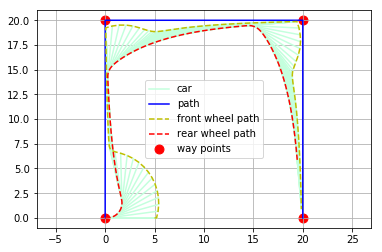

In [155]:
if __name__ == "__main__":
    follow_wp([[0,0],[0,20],[20,20],[20,0]],1)
#     N = 101
#     T = 20
#     t = np.linspace(0, T, N)
    
#     p_old = [0,0]
#     p_new = [0,30]
    
#     k3 = 0.5 # Frontwheel Feedback
#     z0 = [0.1, -0.1, 0]
#     u0 = [0, norm(np.array(p_new)-np.array(p_old),2)/T]
    
    
#     x,y,xf,yf,x_path,y_path,theta = path_control(z0, u0, t, 'frontwheel feedback', k3, path, vhcl_mdl, p_old, p_new)
    
#     plt.figure()
#     plt.axis('equal')
#     plt.plot(x_path, y_path, 'b', label = 'path')
#     plt.plot(xf, yf, 'y--', label = 'front wheel path')
#     plt.plot(x, y, 'r--', label = 'rear wheel path')
#     plt.scatter(x[0], y[0], s = 100, label = 'start')
#     plt.scatter(x[-1], y[-1], s = 100, label = 'end')
#     plt.legend(loc = 'lower right')
#     plt.grid()
#     plt.show()
    